# Quantum Sudoku Solver

This project uses Qiskit to create a quantum circuit that uses Grover's algorithm to solve a $n^2 \times n^2$ sudoku puzzle.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector

import math
import numpy as np

import qc_sudoku

## Representing a sudoku puzzle

For now, we will assume that the input is a $4 \times 4$ sudoku puzzle with a unique solution.
We shall represent such a puzzle as a 2D array.

### Example

Suppose we are given the following sudoku puzzle.

```
2 0 3 1
1 * * 0
0 * * *
3 * * 2
```

We can think of the puzzle as a matrix $(a_{ij})$. (Let's use 0-based indexing.)
The puzzle can be represented as the following array.


In [2]:
puzzle = np.array([[2,0,3,1],[1,np.nan,np.nan,0],[0,np.nan,np.nan,np.nan],[3,np.nan,np.nan,2]])
puzzle

array([[ 2.,  0.,  3.,  1.],
       [ 1., nan, nan,  0.],
       [ 0., nan, nan, nan],
       [ 3., nan, nan,  2.]])

## Qubit representation

To solve this sudoku with Grover's algorithm, we need to represent the puzzle using qubits.
A cell in an $n^2 \times n^2$ puzzle can take on a value from $\{0,1,2,\dots,n^2-1\}$.
The number of bits required to represent $n^2-1$ in binary representation is $\lceil \log_2(n^2) \rceil$, so each cell must be allotted that many qubits.
Our example puzzle is a $4 \times 4$ puzzle, so we need 2 qubits per cell.

In [3]:
qc_sudoku.find_nqubits_per_entry(puzzle)

2

Our quantum circuit will represent each empty (or "unknown") cell using 2 qubits.
Our example has 7 unknown cells, so we will represent these cells using 14 qubits.

# Grover's algorithm

A sudoku puzzle can be thought of as an *unstructured search problem*: given the set of all possible inputs into the empty cells, we are searching for inputs that are a valid solutions.
For an $n^2 \times n^2$ sudoku puzzle with $k$ empty cells, we can think of the search space $S$ as the set of $k$-tuples whose entries may take on values from $\{0,1,2,\dots,n^2-1\}$, i.e. $S = \{0,1,2,\dots,n^2-1\}^k$.
If the puzzle has a unique solution $x_0 \in S$, we can imagine a marker function $f: S \to \{0,1\}$ that "marks" the valid solution $x_0$, i.e. $f^{-1}\{1\} = \{x_0\}$.
A priori, we do not know which element of $S$ is the valid solution, but we can implement $f$ by writing a function that checks if the given input $x$ violates the rules of sudoku.

As described in Section 6.1 of *Quantum Computation and Quantum Information* by Nielsen and Chuang (hereby called "N&C"), Grover's algorithm is a quantum search algorithm that provides a quadratic speed-up for unstructured search, relative to classical algorithms.

Here is a brief overview of Grover's algorithm, assuming there is exactly one solution to the search problem.

1. Suppose the search space can be represented with $K$ qubits. Initialize a $K$-qubit quantum register with the equal superposition state $|\psi\rangle$ to represent the fact that, a priori, each element of the search space is equally probable to be a valid solution to the search problem.
2. Repeatedly apply a "Grover iteration" $G$, consisting of a "marker oracle" $O$ and a "diffusion" operator.
3. After sufficiently many iterations, the state $|\psi\rangle$ converges to a valid solution to the search problem.

The marker oracle $O$ is a unitary operator that flips an ancillary oracle qubit $|q\rangle$ if and only if the input is a valid solution, i.e. $|x\rangle |q\rangle \xrightarrow{O} |x\rangle |q \oplus f(x)\rangle$, where $f$ is the marker function from earlier.
We will discuss the marker oracle, the diffusion operator, and other subcircuits below.

Continuing with our example puzzle, how might we use Grover's algorithm to solve the puzzle?

```
2 0 3 1
1 * * 0
0 * * *
3 * * 2
```

- The search space can be thought of as the 7 empty cells, which can be represented with 14 qubits.
- We'll need one oracle qubit that flips when the oracle detects a valid solution.
- The oracle $O$ somehow needs to be able to check if a given element of the search space is a valid solution, i.e. it needs to check whether the row, column, and "block" rules of sudoku are violated, so we'll need some registers for storing the value of filled (or "known") cells, as well as registers for storing values of intermediate calculations.

Before looking at any subcircuits, let's get an overview of the main circuit to see how everything fits together.


In [4]:
# Print source code
qc_sudoku.grover??

Signature: qc_sudoku.grover(puzzle: numpy.ndarray, niter: int) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def grover(puzzle: np.ndarray, niter: int) -> QuantumCircuit:
    """Returns the Grover circuit for the given puzzle.

    This function assumes the input is an n^2 by n^2 sudoku puzzle, with
    entries in the range [0, n^2-1], with a unique solution.
    The output is the corresponding quantum circuit implementing
    Grover's algorithm, using `niter` Grover iterations.

    #TODO Rewrite to deal with zero or multiple solutions

    Parameters
    ----------
    puzzle : np.ndarray
        n^2 by n^2 array, representing the unsolved puzzle,
        where an empty cell is np.nan
    niter : int
        Number of Grover iterations in the circuit

    Returns
    -------
    QuantumCircuit
        Implements Grover's algorithm for the given sudoku puzzle
    """
    # Important constants
    nrows = puzzle.shape[0]
    nqubits_per_entry = find_nqubits_per_entry(puzzl

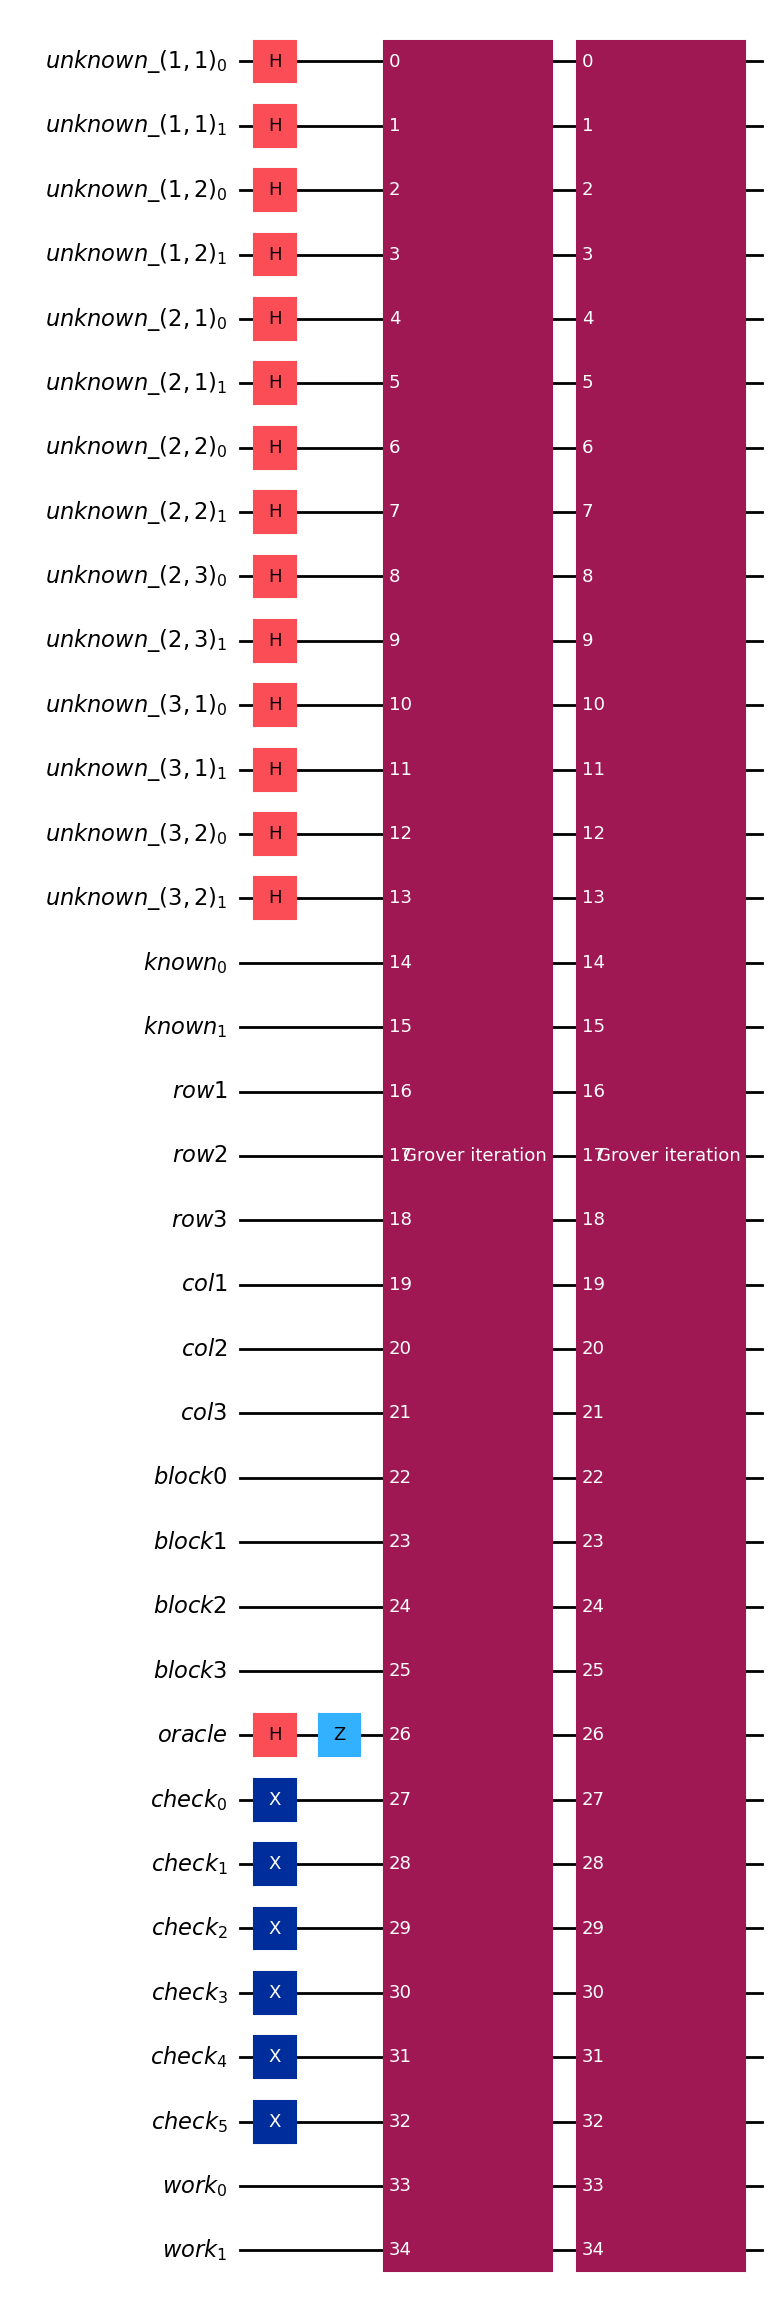

In [5]:
# Draw Grover circuit with 2 Grover iterations
qc_sudoku.grover(puzzle,2).draw("mpl")

In the above circuit with two Grover iterations, each unknown cell gets a quantum register with two qubits.
Indeed, consider the puzzle again.

```
2 0 3 1
1 * * 0
0 * * *
3 * * 2
```

With 0-based indexing, the $(1,2)$-cell is empty, so it gets the register labeled `unknown_(1,2)` with two qubits.

The circuit prepares the 7 registers for the unknown cells with a Hadamard transform $H^{\otimes 14}$.
It also prepares the oracle qubit `oracle` into the "minus state" $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$ by applying $ZH$. (The left-multiplication of $ZH$ shows up in the circuit as applying $H$ first, then $Z$.)

Notice the `known` register, consisting of 2 qubits.
Our example puzzle has 9 filled cells, which would require 18 qubits to represent in the circuit.
We need to store these values in the circuit somehow so that the oracle circuit can use them for checking sudoku rules.
However, instead of using 18 qubits, we can reduce the number of qubits required by instead preparing the `known` register to whatever state we need for the current comparison.

The circuit has `row`, `col`, and `block` registers for checking whether a sudoku rule is satisfied.
For example, if an element of the search space satisfies the rule that none of the entries of row 1 are equal to each other, then the oracle should flip the `row1` qubit from $|0\rangle$ to $|1\rangle$.
The `check` and `work` registers are used for storing values of intermediate computations.
We will explain how the oracle uses these registers later.

In [6]:
nqubits_per_entry = qc_sudoku.find_nqubits_per_entry(puzzle)
num_unknown = qc_sudoku.find_num_unknown(puzzle)
nqubits = nqubits_per_entry * num_unknown
niter = math.ceil(math.pi * math.sqrt(2**nqubits) / 4)

print("Number of qubits per entry: {}".format(nqubits_per_entry))
print("Number of unknown cells: {}".format(num_unknown))
print("Number of qubits to represent the unknown cells: {}".format(nqubits))
print("Number of Grover iterations: {}".format(niter))

Number of qubits per entry: 2
Number of unknown cells: 7
Number of qubits to represent the unknown cells: 14
Number of Grover iterations: 101


For our example puzzle, since there are 14 qubits representing the search space, we need $\lceil \pi \sqrt{2^{14}} / 4 \rceil = 101$ Grover iterations to converge to the valid solution. 
- That's a lot of iterations....
- If we wanted to cut down on the number of iterations, we could use classical sudoku methods to fill in some cells before feeding the puzzle into the circuit. I may implement this feature in a future update.

## Grover iteration

Let's take a look at the Grover iteration circuit for our given puzzle.

In [7]:
# Print source code
qc_sudoku.grover_iteration??

Signature:
qc_sudoku.grover_iteration(
    puzzle: numpy.ndarray,
    nrows: int,
    nqubits_per_entry: int,
    unknown_dict: dict[tuple[int, int], qiskit.circuit.QuantumRegister],
    known_qr: qiskit.circuit.AncillaRegister,
    row_regs: dict[int, qiskit.circuit.AncillaRegister],
    col_regs: dict[int, qiskit.circuit.AncillaRegister],
    block_regs: dict[int, qiskit.circuit.AncillaRegister],
    oracle_qr: qiskit.circuit.AncillaRegister,
    check_qr: qiskit.circuit.AncillaRegister,
    work_qr: qiskit.circuit.AncillaRegister,
) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def grover_iteration(puzzle: np.ndarray,
                    nrows: int,
                    nqubits_per_entry: int,
                    unknown_dict: dict[tuple[int, int], QuantumRegister],
                    known_qr: AncillaRegister,
                    row_regs: dict[int, AncillaRegister],
                    col_regs: dict[int, AncillaRegister],
                    block_regs: dict[int, Anc

In [8]:
# Important constants
nrows = puzzle.shape[0]
nqubits_per_entry = qc_sudoku.find_nqubits_per_entry(puzzle)

# Dictionary with quantum registers for each unknown cell
unknown_dict = qc_sudoku.make_unknown_dict(puzzle)

# Register where state of known cells are prepared
known_qr = AncillaRegister(nqubits_per_entry, name="known")

rows_with_nan = qc_sudoku.find_rows_with_nan(puzzle)
cols_with_nan = qc_sudoku.find_cols_with_nan(puzzle)
blocks_with_nan = qc_sudoku.find_blocks_with_nan(puzzle)

# Rule registers
# Flip if a sudoku rule is satisfied
row_regs = {row : AncillaRegister(1, name="row{}".format(row))
            for row in rows_with_nan}
col_regs = {col : AncillaRegister(1, name="col{}".format(col))
            for col in cols_with_nan}
block_regs = {block : AncillaRegister(1, name="block{}".format(block))
                for block in blocks_with_nan}

# Oracle qubit, which should flip if all rules are satisfied
oracle_qr = AncillaRegister(1, name="oracle")

# In a row, col, or block, there are `nrows` entries.
# We need to check at most (nrows choose 2) pairs of entries and store
# the results in (nrows choose 2) ancilla.
check_qr = AncillaRegister(math.comb(nrows, 2), name="check")

# We also need to `nqubits_per_entry` qubits for `is_equal` to work.
work_qr = AncillaRegister(nqubits_per_entry, name="work")

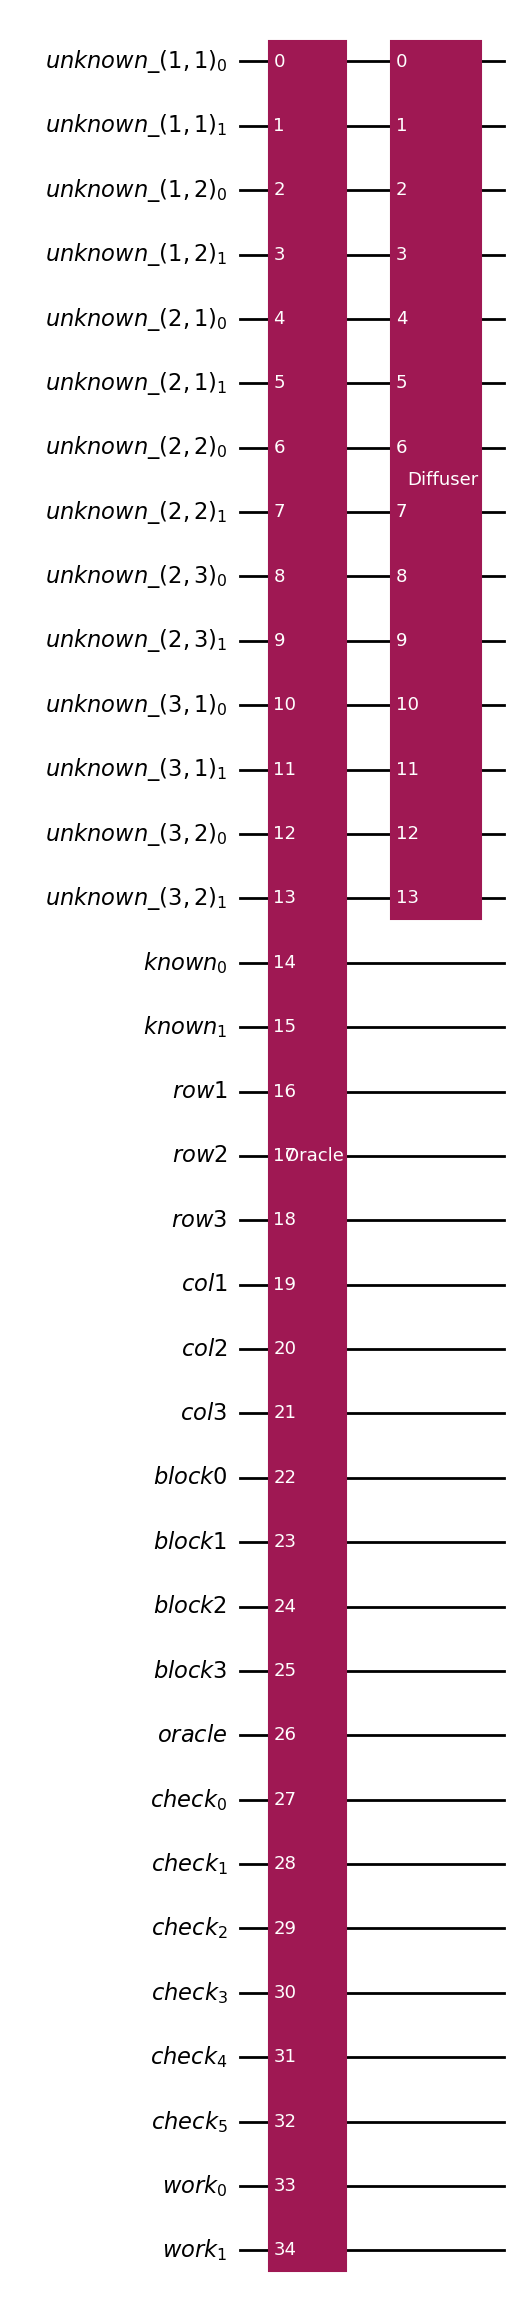

In [9]:
# Draw Grover iteration circuit
qc_sudoku.grover_iteration(puzzle, 
                           nrows, 
                           nqubits_per_entry, 
                           unknown_dict, 
                           known_qr, 
                           row_regs, 
                           col_regs, 
                           block_regs, 
                           oracle_qr, 
                           check_qr, 
                           work_qr
                           ).draw("mpl")


The Grover iteration circuit consists of the oracle subcircuit and the diffuser subcircuit, which we will discuss below.

### Marker oracle

Now let us examine the oracle circuit.

In [10]:
# Print source code
qc_sudoku.oracle??

Signature:
qc_sudoku.oracle(
    puzzle: numpy.ndarray,
    nrows: int,
    nqubits_per_entry: int,
    unknown_dict: dict[tuple[int, int], qiskit.circuit.QuantumRegister],
    known_qr: qiskit.circuit.AncillaRegister,
    row_regs: dict[int, qiskit.circuit.AncillaRegister],
    col_regs: dict[int, qiskit.circuit.AncillaRegister],
    block_regs: dict[int, qiskit.circuit.AncillaRegister],
    oracle_qr: qiskit.circuit.AncillaRegister,
    check_qr: qiskit.circuit.AncillaRegister,
    work_qr: qiskit.circuit.AncillaRegister,
) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def oracle(puzzle: np.ndarray,
            nrows: int,
            nqubits_per_entry: int,
            unknown_dict: dict[tuple[int, int], QuantumRegister],
            known_qr: AncillaRegister,
            row_regs: dict[int, AncillaRegister],
            col_regs: dict[int, AncillaRegister],
            block_regs: dict[int, AncillaRegister],
            oracle_qr: AncillaRegister,
            check_qr:

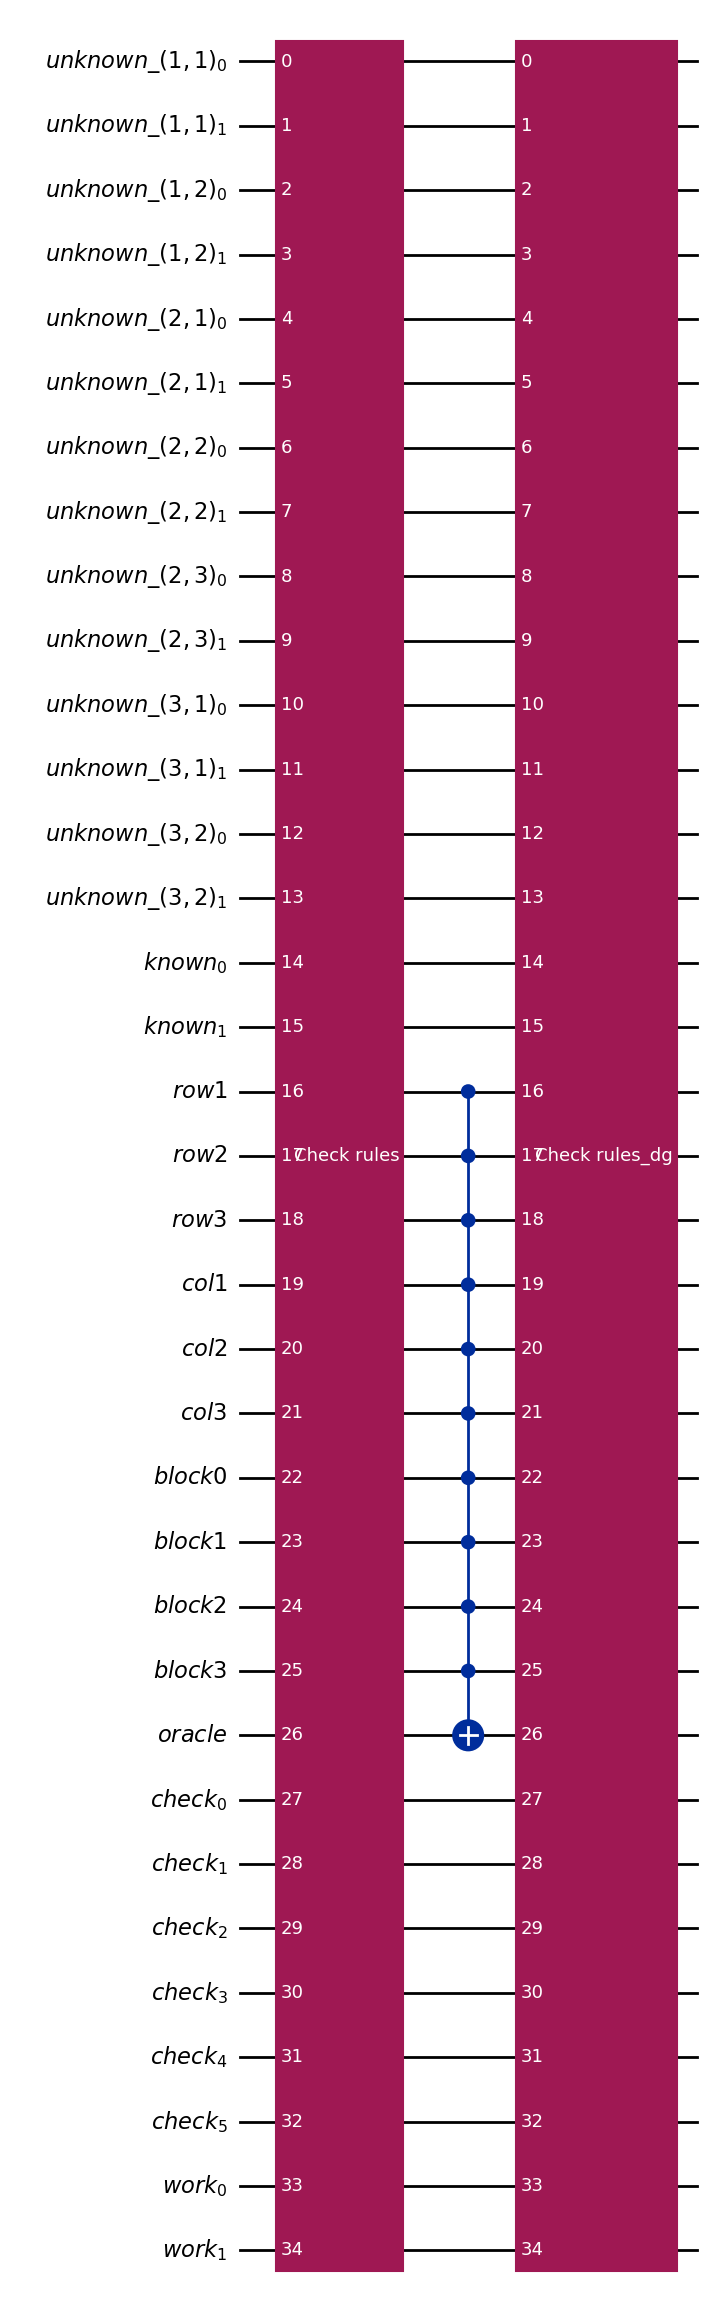

In [11]:
# Draw oracle circuit
qc_sudoku.oracle(puzzle,
                 nrows,
                 nqubits_per_entry,
                 unknown_dict,
                 known_qr,
                 row_regs,
                 col_regs,
                 block_regs,
                 oracle_qr,
                 check_qr,
                 work_qr
                 ).draw("mpl")

The oracle circuit first checks the sudoku rules.
- Using the `check` and `work` registers to store results of intermediate computations, the circuit flips each `row`, `col`, and `block` register when the corresponding sudoku rule is satisfied, i.e. the `row1` qubit is flipped from $|0\rangle$ to $|1\rangle$ if and only if the entries of row 1 are mutually distinct.
- Next, a multicontrolled $X$ gate flips the oracle qubit if and only if all of the `row`, `col`, and `block` registers are flipped, i.e. no sudoku rules are violated.
- Finally, we apply the inverse of the rule-checking operator to uncompute all the ancillas.

Let's examine more closely how the oracle register checks the rules.

In [12]:
# Print source code
qc_sudoku.is_equal??

Signature: qc_sudoku.is_equal(nqubits: int) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def is_equal(nqubits: int) -> QuantumCircuit:
    """Returns a quantum circuit that flips an output qubit if two input
    registers have the same state.

    Parameters
    ----------
    nqubits : int
        Size of each of the two input registers

    Returns
    -------
    QuantumCircuit
    """
    in_qr1 = QuantumRegister(nqubits, name="x")
    in_qr2 = QuantumRegister(nqubits, name="y")
    out_qr = AncillaRegister(1, name="out")

    # We need to do `nqubits` comparisons, so we need that many qubits
    work_qr = AncillaRegister(nqubits, name="w")

    qc = QuantumCircuit(in_qr1, in_qr2, out_qr, work_qr, name="Is equal")

    # Store comparisons in work ancilla
    for i in range(nqubits):
        qc.compose(XOR_qc().to_gate(),
                    qubits=[in_qr1[i], in_qr2[i], work_qr[i]],
                    inplace=True)

    # Flip target_qr iff all work ancilla are 1
   

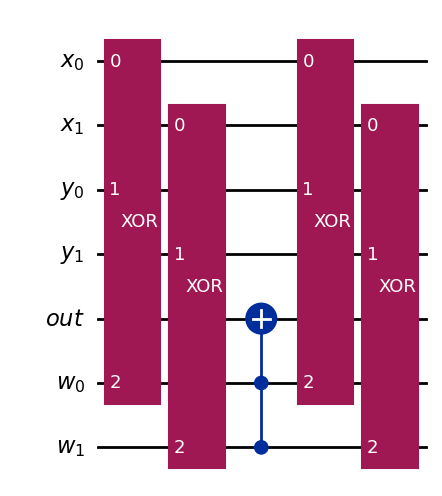

In [13]:
# Draw is_equal circuit
qc_sudoku.is_equal(nqubits_per_entry).draw("mpl")

In [14]:
# Print source code
qc_sudoku.XOR_qc??

Signature: qc_sudoku.XOR_qc() -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def XOR_qc() -> QuantumCircuit:
    """Returns a quantum circuit corresponding to logical XOR.
    """
    in_qr = QuantumRegister(2, name="in")
    out_qr = AncillaRegister(1, name="out")
    qc = QuantumCircuit(in_qr, out_qr, name="XOR")
    qc.cx(in_qr[0], out_qr[0])
    qc.cx(in_qr[1], out_qr[0])
    return qc
File:      ~/qc-sudoku-solver/qc_sudoku.py
Type:      function

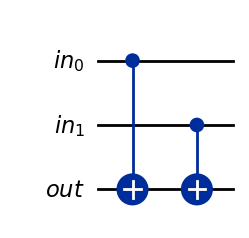

In [15]:
# Draw XOR circuit
qc_sudoku.XOR_qc().draw("mpl")

The `is_equal` subroutine flips an output qubit if and only if two input registers are equal.
- For our $4 \times 4$ puzzle, the input registers `x` and `y` each require 2 qubits.
- Each XOR gate flips an ancilla register if and only if the two inputs are equal. For example, the first XOR gate flips in the `is_equal` circuit flips the `w_0`qubit if and only if the `x0` and `y0` qubits are equal.
- Thus, the `w0` and `w1` qubits are both flipped to $|1\rangle$ if and only if $x=y$.
- The doubly-controlled $X$ gate flips the output qubit `out` if and only if both `w0` and `w1` are flipped, i.e. if and only if $x=y$.
- Of course, we must apply the XOR gates again to uncompute the `w0` and `w1` registers.

The oracle circuit uses this `is_equal` circuit to check if two cells have the same value.
To see how, let us examine the `is_valid_group` circuit.

In [16]:
# Print source code
qc_sudoku.is_valid_group??

Signature:
qc_sudoku.is_valid_group(
    group: numpy.ndarray,
    nqubits_per_entry: int,
    unknown_regs: tuple[qiskit.circuit.QuantumRegister, ...],
    known_qr: qiskit.circuit.AncillaRegister,
    group_qr: qiskit.circuit.AncillaRegister,
    check_qr: qiskit.circuit.AncillaRegister,
    work_qr: qiskit.circuit.AncillaRegister,
) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def is_valid_group(group: np.ndarray,
                    nqubits_per_entry: int,
                    unknown_regs: tuple[QuantumRegister, ...],
                    known_qr: AncillaRegister,
                    group_qr: AncillaRegister,
                    check_qr: AncillaRegister,
                    work_qr: AncillaRegister
    ) -> QuantumCircuit:
    """Returns a quantum circuit that checks if the grouping is valid.

    Let's call a row, column, or block, a "group" of cells.
    Given a group, this function flips an output register iff all
    cells in the grouping are distinct.

    Para

In [17]:
# Let's say we want to check if row 1 is a valid group
row = 1
group = puzzle[row,:]

unknown_regs = []

for col in range(nrows):
    if (row,col) in unknown_dict:
        reg = unknown_dict.get((row,col))
        unknown_regs.append(reg)
unknown_regs = tuple(unknown_regs)

group_qr = row_regs.get(row)

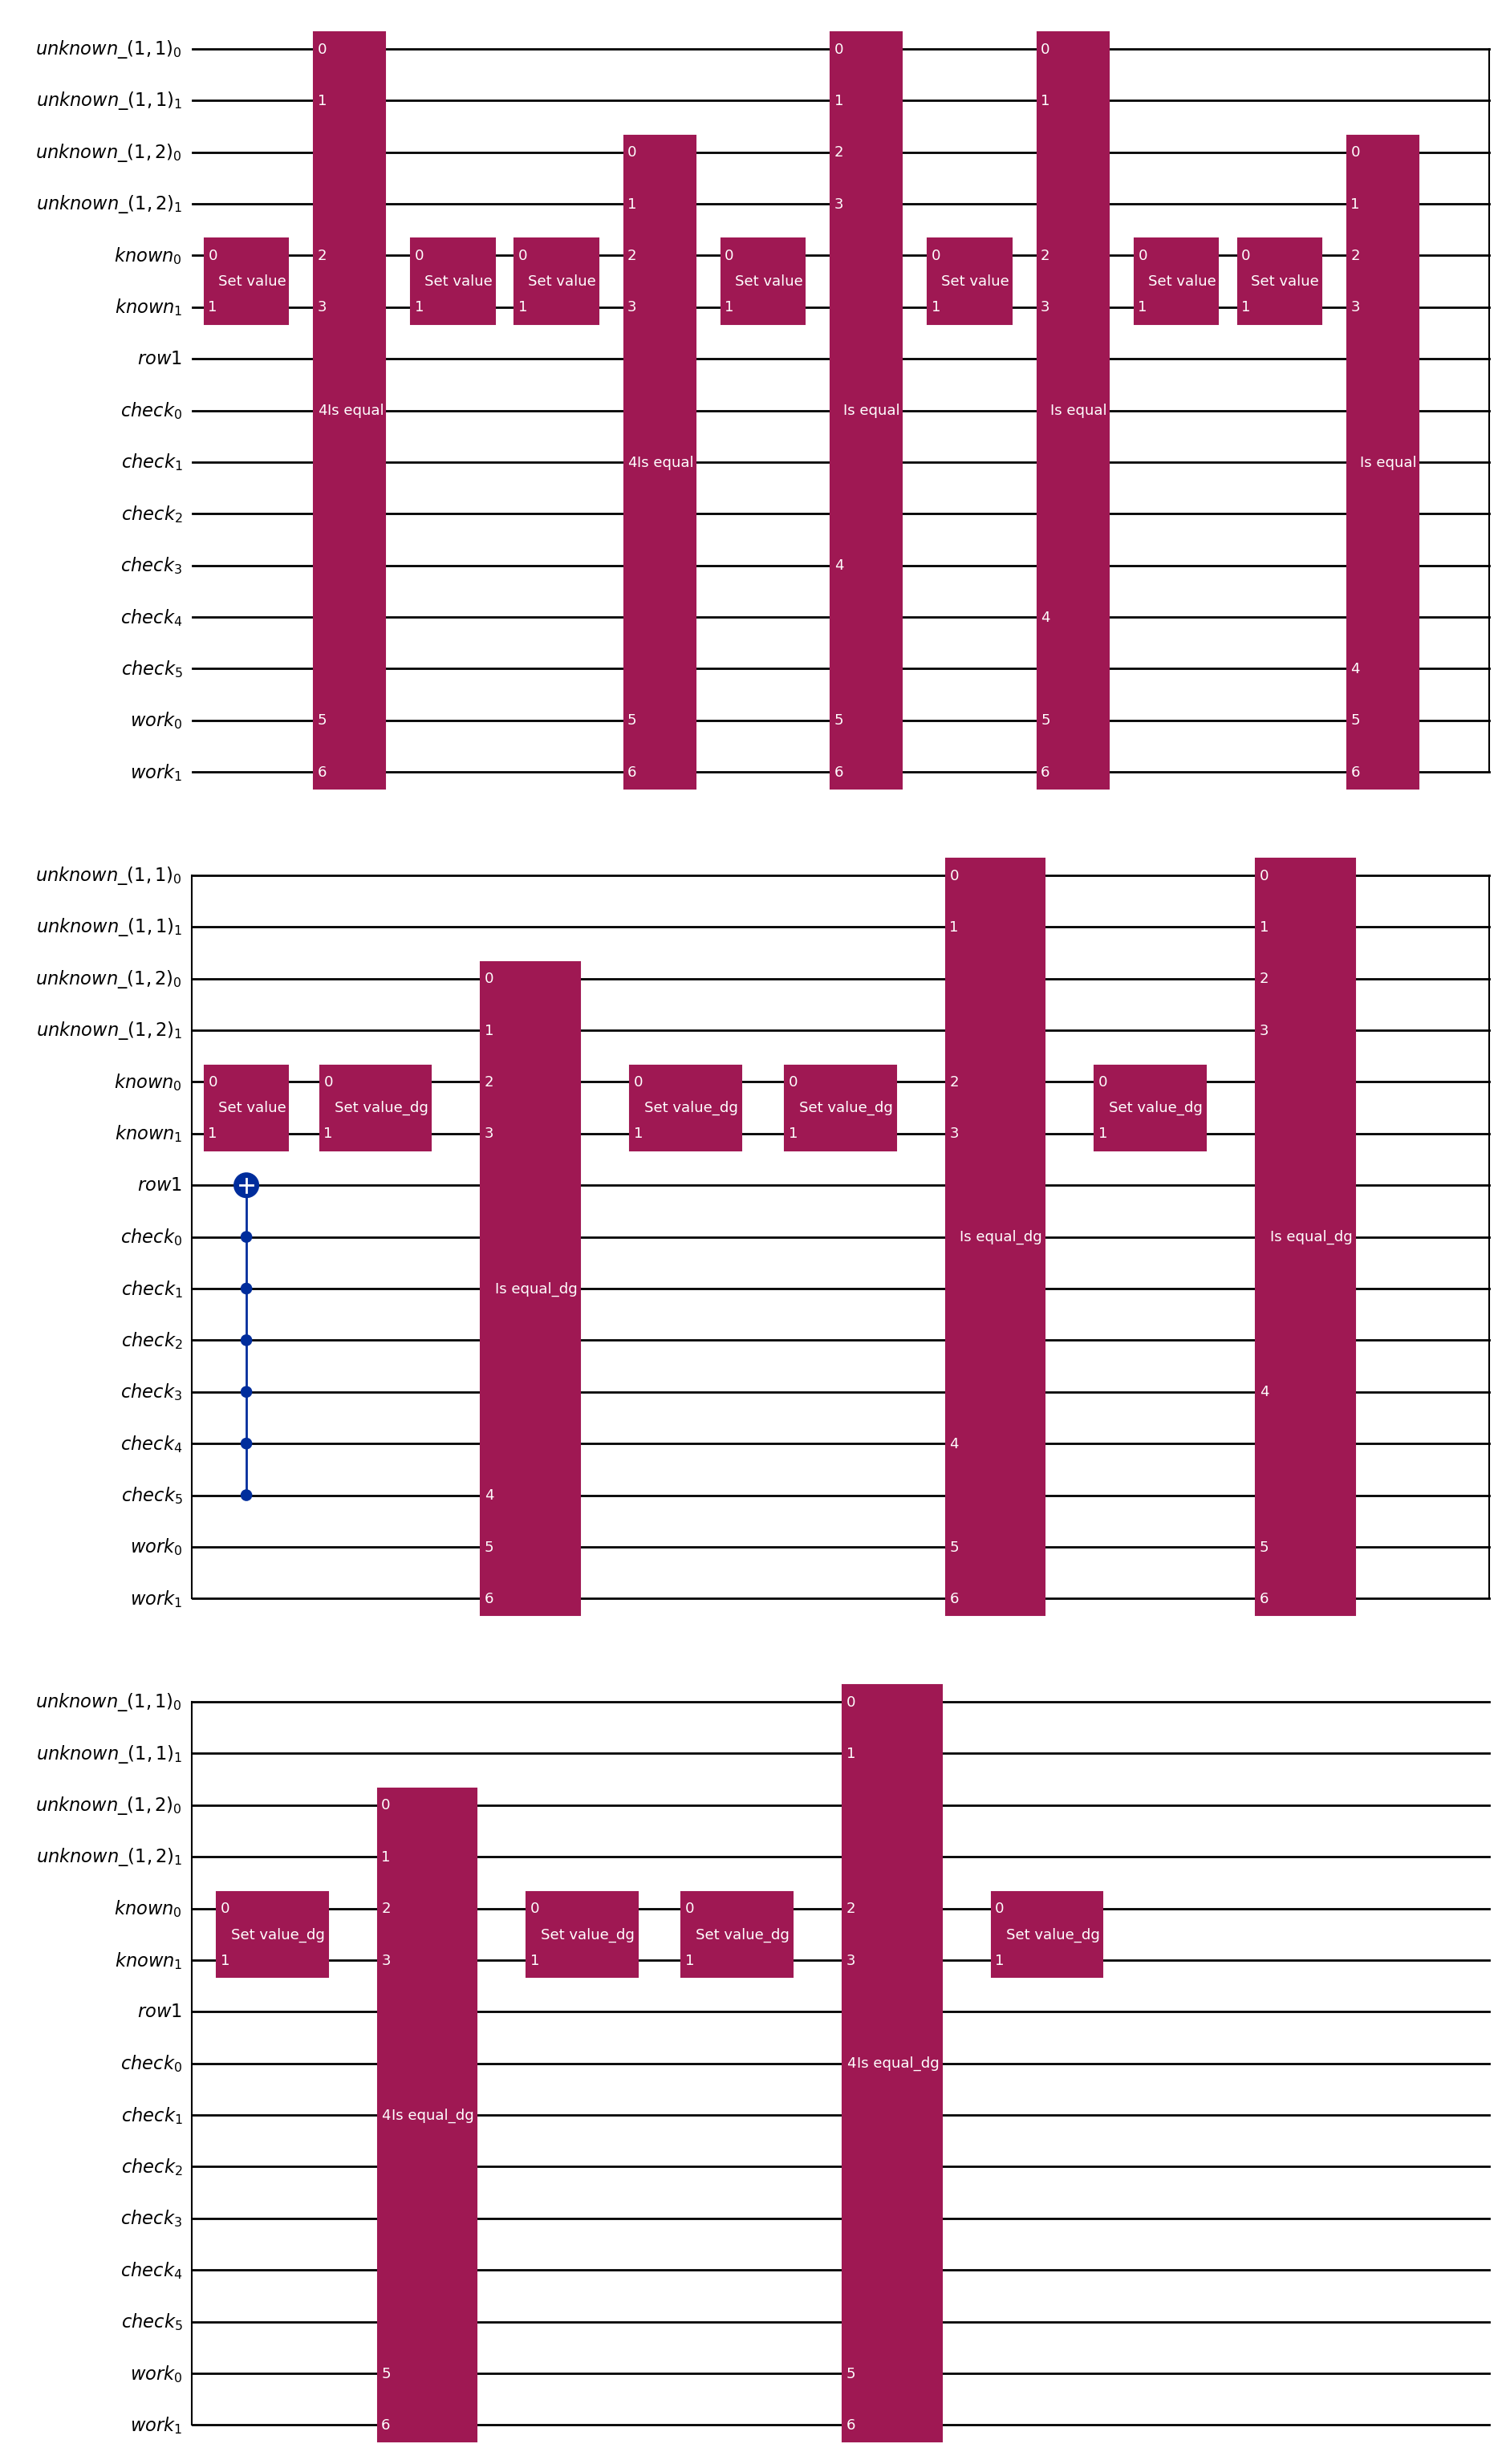

In [18]:
# Draw is_valid_group circuit
qc_sudoku.is_valid_group(group,
                         nqubits_per_entry,
                         unknown_regs,
                         known_qr,
                         group_qr,
                         check_qr,
                         work_qr
                         ).draw("mpl")

In [19]:
# Print source code
qc_sudoku.value_to_ancilla??

Signature: qc_sudoku.value_to_ancilla(value: int, nqubits: int) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def value_to_ancilla(value: int, nqubits: int) -> QuantumCircuit:
    """Returns a quantum circuit that stores the given value in the
    ancilla register.

    Parameters
    ----------
    value : int
        Value to be stored
    nqubits : int
        Size of the register where the value will be stored
    """
    qr = AncillaRegister(nqubits, name="a")
    qc = QuantumCircuit(qr, name="Set value")

    # If value == 0, we want an empty gate
    if value == 0:
        return qc
    else:
        bitstr = int_to_bitstr(value, nqubits)
        assert len(bitstr) == nqubits

        # Note that higher index in the register means more significant
        # so we need to reverse the bitstring
        bitstr = bitstr[::-1]

        qc.x([qr[i] for i in range(len(bitstr)) if bitstr[i] == "1"])

        return qc
File:      ~/qc-sudoku-solver/qc_sudoku.py
Type:      fu

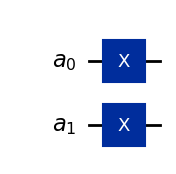

In [20]:
# Let's say we are storing the value 3 in a register of size 2
# In binary, 3 is 11, so to prepare the two qubits, we should flip both qubits
# Draw circuit for preparing a 2-qubit register with the integer 3
qc_sudoku.value_to_ancilla(3,2).draw("mpl")

The `is_valid_group` circuit checks if a given "group" is valid.
In our example, suppose that we are checking if row 1 is valid, i.e. the entries of row 1 are mutually distinct.

```
2 0 3 1
1 * * 0
0 * * *
3 * * 2
```

The unknown cells in row 1 are $(1,1)$ and $(1,2)$, each of which gets 2 qubits.
We need to perform the following comparisons.
- $(1,0)$ and $(1,1)$
- $(1,0)$ and $(1,2)$
- We do not need to compare $(1,0)$ and $(1,3)$, because they are filled cells
- $(1,1)$ and $(1,2)$
- $(1,1)$ and $(1,3)$
- $(1,2)$ and $(1,3)$

To compare a filled cell (say $(1,0)$) and an unfilled cell (say $(1,1)$), we conduct the following procedure.
- First prepare the `known` register with the value of the filled cell by using the `value_to_ancilla` subcircuit.
- Next, we use the `is_equal` subcircuit to compare the `unknown_(1,1)` register with the `known` register.
- The corresponding `check` qubit is flipped when the two registers are equal.

To compare an unfilled cell with another unfilled cell, (say $(1,1)$ and $(1,2)$), we conduct the following procedure.
- Use the `is_equal` subcircuit to compare the `unknown_(1,1)` register with the `unknown_(1,2)` register.
- The corresponding `check` qubit is flipped when the two registers are equal.

Recall that the `check` register is initialized with the all-ones state at the beginning of the Grover circuit.
Thus, for a given comparison, the corresponding `check` qubit flips to $|0\rangle$ if and only if the two compared registers are equal.
Consequently, after all the comparisons are done, the `check` register is in the all-ones state if and only if none of the registers are equal, i.e. the sudoku rule is satisfied.

At this point, the `is_valid_group` circuit applies a multicontrolled $X$ gate to the `row1` qubit, controlled by the `check` register.
The `row1` qubit is flipped to $|1\rangle$ if and only if the `check` register is in the all-ones state, i.e. the entries of row 1 are mutually distinct.

Finally, we uncompute the ancilla registers by undoing the state preparations and comparison circuits.



The oracle circuit uses the `is_valid_group` subcircuit to check each row, column, and block, flipping the corresponding `row`, `col`, and `block` qubits if and only if the sudoku rules are satisfied.
The oracle circuit then applies a multicontrolled $X$ gate to the oracle qubit controlled by the `row`, `col`, and `block` circuits, flipping the oracle qubit if and only if all sudoku rules are satisfied.
Finally, the oracle circuit uncomputes all the ancillas.

### Grover diffuser

The Grover diffuser is relatively straightforward.
The following circuit applies steps 2-4 in the Grover iteration procedure from Section 6.1.2 of N&C.

In [21]:
# Print source code
qc_sudoku.grover_diffuser??

Signature: qc_sudoku.grover_diffuser(nqubits: int) -> qiskit.circuit.quantumcircuit.QuantumCircuit
Source:   
def grover_diffuser(nqubits: int) -> QuantumCircuit:
    """Returns the Grover diffuser circuit on `nqubits` qubits.

    This circuit is used to perform a conditional phase shift on the
    registers corresponding to unknown cells of the puzzle.
    """
    qr = QuantumRegister(nqubits, name="x")
    qc = QuantumCircuit(qr, name="Diffuser")

    qc.h(qr)
    qc.x(qr)

    # Not sure if there is a method like qc.mcz()
    # Multi-controlled Z is equivalent to the following
    qc.h(qr[-1])
    qc.mcx(qr[:-1], qr[-1])
    qc.h(qr[-1])

    qc.x(qr)
    qc.h(qr)

    #print("diffuser success")
    return qc
File:      ~/qc-sudoku-solver/qc_sudoku.py
Type:      function

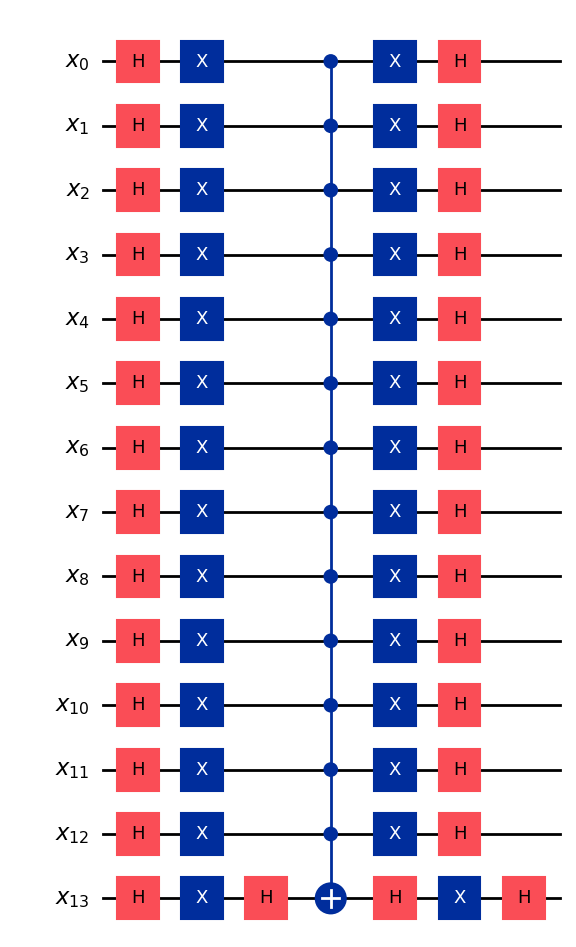

In [22]:
# Draw the diffuser circuit
qc_sudoku.grover_diffuser(nqubits).draw("mpl")

# Recap

To summarize, the `grover` circuit works as follows.
1. Prepares the `unknown` registers and `oracle` qubit.
2. For each Grover iteration, first apply the `oracle` subcircuit, which compares relevant registers and checks the rules of sudoku.
3. After applying the `oracle` subcircuit, apply the `grover_diffuser` subcircuit.
4. Apply enough Grover iterations for the state to converge to a valid solution.

At this point, one may measure the registers corresponding to unknown cells to get a valid solution to the input sudoku puzzle.

# References

- *Quantum Computation and Quantum Information* by Nielsen and Chuang